# 1. Kütüphanelerin Yüklenmesi

Bu bölümde, projede kullanacağımız temel kütüphaneleri içe aktarıyoruz:
- **Pandas, NumPy** gibi veri işleme kütüphaneleri  
- **scikit-learn** (train-test bölme ve metrikler)  
- **TensorFlow/Keras** (model oluşturma, katman ekleme, optimizer, callbacks)  
- **Matplotlib, Seaborn** (görselleştirme)  
- **glob** (dosya yolları için)  
Ayrıca gereksiz uyarıları bastırmak için `warnings.filterwarnings("ignore")` kullanıyoruz.


In [15]:
# Veri işleme kütüphaneleri
import pandas as pd
import numpy as np
import glob

# Model oluşturma ve performans ölçüm kütüphaneleri
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import DenseNet121, MobileNet
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Görselleştirme kütüphaneleri
import matplotlib.pyplot as plt
import seaborn as sns

# Uyarıları bastırmak için
import warnings
warnings.filterwarnings("ignore")

print("Tüm kütüphaneler başarıyla yüklendi.")


Tüm kütüphaneler başarıyla yüklendi.


# 2. Veri Seti Dizinlerinin Tanımlanması ve Dosya Yollarının Alınması

*with_mask_path* ve *without_mask_path* değişkenleri ile maske takan ve takmayan görüntülerin klasörlerini belirliyoruz.  
Daha sonra `glob.glob()` fonksiyonu kullanarak, ilgili klasörlerdeki tüm dosyaların yolunu liste şeklinde alıyoruz.  
Bu listeleri ekranda göstererek doğru dosya yollarına erişip erişmediğimizi kontrol ediyoruz.


In [3]:

# Veri seti dizinlerini tanımla
with_mask_path = "data/with_mask/*"
without_mask_path = "data/without_mask/*"

# Dosya yollarını al
with_mask_files = glob.glob(with_mask_path)
without_mask_files = glob.glob(without_mask_path)

with_mask_files
without_mask_files


['data/without_mask/without_mask_3593.jpg',
 'data/without_mask/without_mask_2855.jpg',
 'data/without_mask/without_mask_1384.jpg',
 'data/without_mask/without_mask_1390.jpg',
 'data/without_mask/without_mask_2699.jpg',
 'data/without_mask/without_mask_3587.jpg',
 'data/without_mask/without_mask_2841.jpg',
 'data/without_mask/without_mask_2869.jpg',
 'data/without_mask/without_mask_293.jpg',
 'data/without_mask/without_mask_287.jpg',
 'data/without_mask/without_mask_1347.jpg',
 'data/without_mask/without_mask_3550.jpg',
 'data/without_mask/without_mask_2896.jpg',
 'data/without_mask/without_mask_2128.jpg',
 'data/without_mask/without_mask_3236.jpg',
 'data/without_mask/without_mask_1421.jpg',
 'data/without_mask/without_mask_1435.jpg',
 'data/without_mask/without_mask_3222.jpg',
 'data/without_mask/without_mask_3544.jpg',
 'data/without_mask/without_mask_278.jpg',
 'data/without_mask/without_mask_2882.jpg',
 'data/without_mask/without_mask_1353.jpg',
 'data/without_mask/without_mask_25

# 3. DataFrame Oluşturma

Önce, maske takan (`with_mask`) ve maske takmayan (`without_mask`) resim yollarını tek bir listeye etiketiyle beraber ekliyoruz. Ardından bu listeyi bir **pandas DataFrame**'e dönüştürüyoruz:

- **image_path**: Görsel dosyasının tam yolu  
- **label**: `"with_mask"` veya `"without_mask"`

Böylece görsellerin yol bilgisi ile etiketlerini tek tabloda tutmuş oluyoruz.

In [4]:

# Klasörlerdeki tüm görsellerin yolunu topla
with_mask_images = glob.glob(with_mask_path)
without_mask_images = glob.glob(without_mask_path)

# DataFrame oluşturalım
data = []
for img in with_mask_images:
    data.append((img, "with_mask"))  # with_mask

for img in without_mask_images:
    data.append((img, "without_mask"))  #  without_mask

df = pd.DataFrame(data, columns=["image_path", "label"])
df.head()


,image_path,label
0,data/with_mask/with_mask_2140.jpg,with_mask
1,data/with_mask/with_mask_1449.jpg,with_mask
2,data/with_mask/with_mask_2626.jpg,with_mask
3,data/with_mask/with_mask_942.jpg,with_mask
4,data/with_mask/with_mask_3538.jpg,with_mask


# 4. Train / Test Ayrımı

Veri setini %20'si test, %80'i eğitim+validasyon olacak şekilde ayırıyoruz.  
`stratify=df["label"]` kullanmak, veri setinde her iki sınıfın da oransal dağılımını koruyarak bölmemizi sağlar.  
`random_state=42` sabit tutularak, bölme işleminin tekrarlanabilir olması sağlanır.  

Çıktıda, eğitim+validasyon seti ile test setinin boyutu görünecektir.


In [5]:

train_df, test_df = train_test_split(
    df,
    test_size=0.2,           # %20 test
    stratify=df["label"],    # Sınıf dengesini korumak için
    random_state=42
)

print("Eğitim+Validasyon seti:", train_df.shape)
print("Test seti:", test_df.shape)


Eğitim+Validasyon seti: (6042, 2)
Test seti: (1511, 2)


# 5. Eğitim / Validasyon Ayrımı

Eğitim+validasyon olarak ayırdığımız kısım içinden tekrar %80 eğitim ve %20 validasyon şeklinde bölme yapıyoruz.  
Tekrar `stratify` ile sınıfların dengeli dağılımı korunuyor.  
Çıktıda, eğitim seti ve validasyon seti boyutlarını doğruluyoruz.

In [6]:
train_df, val_df = train_test_split(
    train_df,
    test_size=0.2,                # %80'e %20
    stratify=train_df["label"],   # Stratify yine sınıf dengesini koruyor
    random_state=42
)

print("Eğitim seti:", train_df.shape)
print("Validasyon seti:", val_df.shape)


Eğitim seti: (4833, 2)
Validasyon seti: (1209, 2)


# 6. ImageDataGenerator Kurulumu (Veri Arttırma)

Eğitim verisi için:
- `rotation_range=10`, `width_shift_range=0.1`, `height_shift_range=0.1`, `zoom_range=0.1`, `horizontal_flip=True` vb. parametrelerle **veri arttırma** yapıyoruz.
- Piksel değerlerini 0-1 aralığına ölçeklemek için `rescale=1.0/255` kullanıyoruz.

Validasyon ve test aşamalarında ise genellikle sadece `rescale=1.0/255` yapıyoruz; başka bir dönüşüm uygulanmıyor.


In [7]:
# Eğitim için veri arttırma
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validasyon / Test için sadece rescale
val_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)


# 7. Generator’ların Oluşturulması

`flow_from_dataframe` fonksiyonu ile:
- `train_df`, `val_df`, `test_df` içindeki `image_path` ve `label` sütunlarını baz alarak **ImageDataGenerator** nesnelerini oluşturuyoruz.
- `target_size=(160,160)` ile resimleri 160x160’a yeniden boyutlandırıyoruz.
- `class_mode="categorical"` seçerek, iki sınıflı bir **one-hot** etiket formatı belirlenmiş oluyor.
- `batch_size=32` her adımda 32 görüntü ve etiketi yüklenmesini sağlıyor.


In [9]:
image_size = (160, 160)
batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="label",
    target_size=image_size,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True,
    validate_filenames=True,        # Bozuk dosyaları kontrol et
    ignore_missing_files=True       # Eksik dosyaları atla
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="image_path",
    y_col="label",
    target_size=image_size,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,
    validate_filenames=True,        # Bozuk dosyaları kontrol et
    ignore_missing_files=True       # Eksik dosyaları atla
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col="label",
    target_size=image_size,
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False,
    validate_filenames=True,        # Bozuk dosyaları kontrol et
    ignore_missing_files=True       # Eksik dosyaları atla
)


Found 4833 validated image filenames belonging to 2 classes.
Found 1209 validated image filenames belonging to 2 classes.
Found 1511 validated image filenames belonging to 2 classes.


# 8. MobileNet Tabanlı Modelin Oluşturulması

Burada, **önceden eğitilmiş** bir `MobileNet` modelinin son katmanlarını çıkarıyoruz (`include_top=False`). Ardından:
1. **GlobalAveragePooling2D** katmanıyla uzamsal boyutları sıkıştırıyoruz.  
2. Bir **Dropout(0.5)** ekleyerek overfitting riskini azaltıyoruz.  
3. Birkaç **Dense** katman (256, 256, 128, 64 nöronlu, ReLU aktivasyonlu) ekliyoruz.  
4. Son katman olarak **2 nöron** ve `softmax` aktivasyon ile 2 sınıf ("with_mask", "without_mask") için çıktı alıyoruz.


In [10]:
base_model = MobileNet(
    weights='mobilenet_1_0_160_tf_no_top.h5',
    include_top=False,
    input_shape=(160, 160, 3)
)


x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dense(256, activation='relu')(x)
x = Dense(128, activation='relu')(x)
x = Dense(64, activation='relu')(x)
predictions = Dense(2, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# 9. Modelin Derlenmesi ve Callbacks

- **Optimizasyon**: `Adam(learning_rate=0.001)`  
- **Kayıp Fonksiyonu**: `categorical_crossentropy`  
- **Metrik**: `accuracy`  

**Callbacks**:
- **EarlyStopping** (`patience=25`, `monitor="val_loss"`) -> 25 epok boyunca iyileşme olmazsa eğitim durur, en iyi ağırlıkları geri yükler.  
- **ReduceLROnPlateau** (`factor=0.1`, `patience=5`, `min_lr=1e-7`) -> Validasayon kaybı iyileşmezse öğrenme oranı otomatik olarak düşer.


In [11]:
optimizer = Adam(learning_rate=0.001)  # Örn. Adam / SGD

model.compile(
    optimizer=optimizer,
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=25,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=5,
    min_lr=1e-7
)


# 10. Modeli Eğitme (Fit İşlemi)

`model.fit` metodu ile:
- `train_generator` üzerinden model eğitilir,  
- `val_generator` ile doğrulama değerleri hesaplanır,  
- `epochs=100` gibi bir sayı belirlenir, fakat EarlyStopping devreye girerse bu sayıdan önce de durabilir.  
Her epok sonunda train/val kaybı ve doğruluk (loss, accuracy) ekrana yazdırılır.


In [12]:
epochs = 100

history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=[early_stopping, reduce_lr]
)


Epoch 1/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 112s 703ms/step - accuracy: 0.9260 - loss: 0.1687 - val_accuracy: 0.9901 - val_loss: 0.0314 - learning_rate: 0.0010
Epoch 2/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 97s 640ms/step - accuracy: 0.9829 - loss: 0.0453 - val_accuracy: 0.9677 - val_loss: 0.1308 - learning_rate: 0.0010
Epoch 3/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 98s 647ms/step - accuracy: 0.9924 - loss: 0.0293 - val_accuracy: 0.9620 - val_loss: 0.1162 - learning_rate: 0.0010
Epoch 4/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 105s 687ms/step - accuracy: 0.9877 - loss: 0.0354 - val_accuracy: 0.9835 - val_loss: 0.0566 - learning_rate: 0.0010
Epoch 5/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 103s 676ms/step - accuracy: 0.9871 - loss: 0.0398 - val_accuracy: 0.9835 - val_loss: 0.0659 - learning_rate: 0.0010
Epoch 6/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 100s 654ms/step - accuracy: 0.9903 - loss: 0.0288 - val_accuracy: 0.9471 - val_loss: 0.1871 - learning_rate: 0.0010
Epoch 7/100
152/152 ━━━━━━━━━━━━━━━━━━━━ 97s 635ms/step - ac

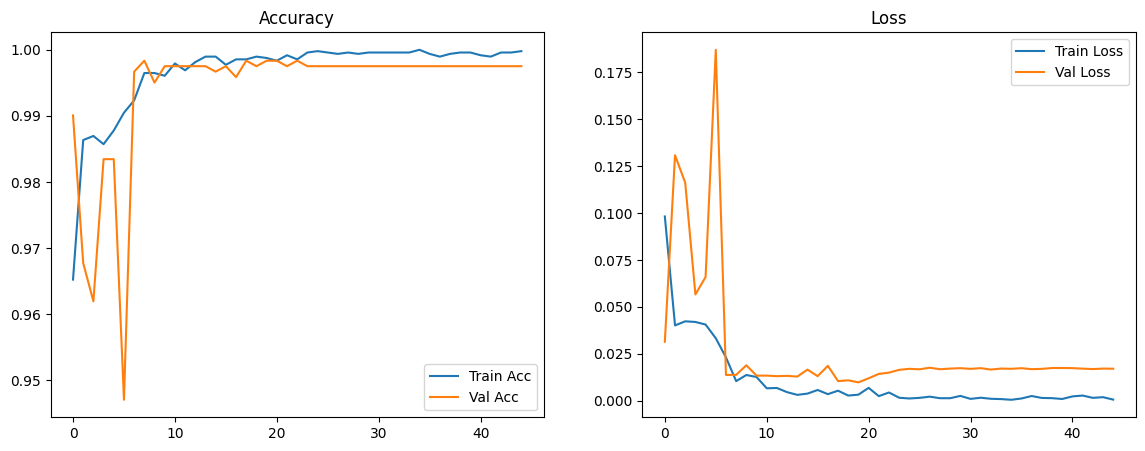

In [13]:
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.legend()
plt.title("Accuracy")

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.legend()
plt.title("Loss")
plt.show()


# 12. Test Seti Üzerinde Tahmin

- `model.predict(test_generator)` ile **test** setindeki her örnek için [p0, p1] şeklinde olasılıklar alırız.  
- `np.argmax(y_pred, axis=1)` ifadesiyle en yüksek olasılığa sahip sınıfın indeksini (0 veya 1) elde ederiz.  
- `train_generator.class_indices` hangi etiketi 0'a, hangisini 1'e atadığını gösterir. Buna göre `test_df["label"]` sütunundaki string etiketleri 0/1’e dönüştürürüz.


In [14]:
# Test seti üzerinde tahmin
y_pred = model.predict(test_generator)               # (num_test_samples, 2) boyutunda olasılık vektörleri
y_pred_classes = np.argmax(y_pred, axis=1)          # 0 veya 1 sınıf indeksleri

# class_indices'ü kontrol edelim:
print("Class Indices (train_generator):", train_generator.class_indices)
# Örnek çıktı: {"with_mask": 0, "without_mask": 1}  -- Bu sadece ÖRNEK

# DataFrame'deki string etiketleri numeric hale getiriyoruz:
# Aşağıdaki map sözlüğü, class_indices ile ÖRTÜŞMELİDİR. 
test_df["numeric_label"] = test_df["label"].map({
    "with_mask": 0,
    "without_mask": 1
})

# Doğru etiketler
y_true = test_df["numeric_label"].values


48/48 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step
Class Indices (train_generator): {'with_mask': 0, 'without_mask': 1}


In [16]:

cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:\n", cm)

# Hangi sınıf index hangi etiket? Yukarıda "with_mask"=0, "without_mask"=1 dedik
print(classification_report(
    y_true, 
    y_pred_classes,
    target_names=["with_mask", "without_mask"]
))


Confusion Matrix:
 [[743   2]
 [  3 763]]
              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       745
without_mask       1.00      1.00      1.00       766

    accuracy                           1.00      1511
   macro avg       1.00      1.00      1.00      1511
weighted avg       1.00      1.00      1.00      1511



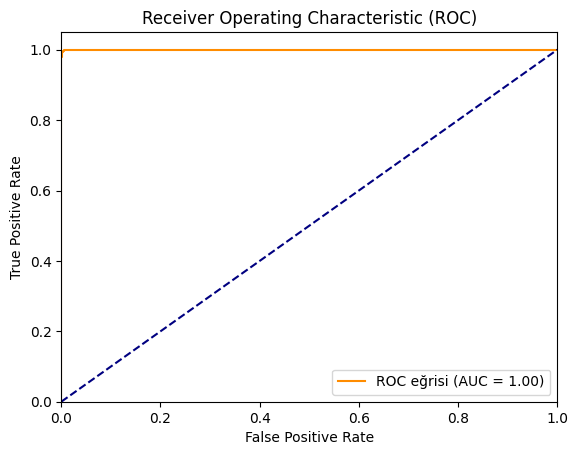

AUC: 0.9998685755340213


In [17]:

# '1' sınıfının (with_mask veya without_mask hangisi pozitif ise) olasılığını alıyoruz
# Örneğin "without_mask"=1 ise:
y_pred_prob = y_pred[:, 1]

fpr, tpr, thresholds = roc_curve(y_true, y_pred_prob, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', label='ROC eğrisi (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Rastgele sınıflandırma çizgisi
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

print("AUC:", roc_auc)


In [18]:
# cm = confusion_matrix(y_true, y_pred_classes)
# cm layout:
# [ [TN, FP],
#   [FN, TP] ]
# Bu layout, pozitif sınıf 1 ise,
# row 0 => actual 0, row 1 => actual 1
# col 0 => predicted 0, col 1 => predicted 1

TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]
TP = cm[1, 1]

specificity = TN / (TN + FP) if (TN + FP) != 0 else 0
print("Specificity:", specificity)


Specificity: 0.9973154362416108
